In [1]:
import os
import subprocess
import sys

# WandB import
import wandb
try:
    from kaggle_secrets import UserSecretsClient
except ImportError:
    # Fallback for environments where kaggle_secrets is not available
    UserSecretsClient = None
    print("Warning: kaggle_secrets.UserSecretsClient not found. WandB API key needs to be set manually via environment variable.")


# Configure basic logging (MOVED EARLIER)
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

# WandB configuration (USER: PLEASE REPLACE 'your-project-name' with your actual project name)
os.environ["WANDB_PROJECT"] = "grit-gpt2-medium-alpaca-finetune" 
os.environ["WANDB_LOG_MODEL"] = "checkpoint"  # Log checkpoints during training (optional)

def install_packages():
    """Installs required packages if not already present."""
    packages = ["tiktoken", "matplotlib"]
    for package in packages:
        try:
            __import__(package)
            print(f"{package} is already installed.")
        except ImportError:
            print(f"Installing {package}...")
            try:
                subprocess.check_call([sys.executable, "-m", "pip", "install", package])
                print(f"{package} installed successfully.")
            except subprocess.CalledProcessError as e:
                print(f"Error installing {package}: {e}")
                # Optionally, exit or raise an error if a critical package fails to install
                # sys.exit(f"Failed to install critical package: {package}")

# Call package installation at the beginning
# In a real Kaggle notebook, these might be !pip install commands in a cell.
# For a script, this approach is more robust.
# install_packages() # Uncomment if running in an environment where packages might be missing

# Setup WandB Authentication
def setup_auth():
    """Set up WandB authentication using Kaggle secrets."""
    if UserSecretsClient:
        try:
            user_secrets = UserSecretsClient()
            wandb_api_key = user_secrets.get_secret("WANDB_API_KEY")
            wandb.login(key=wandb_api_key)
            logger.info("Successfully logged in to Weights & Biases using Kaggle secrets.")
        except Exception as e:
            logger.error(f"Failed to login to WandB using Kaggle secrets: {e}. "
                         f"Ensure WANDB_API_KEY secret is set in Kaggle or WANDB_API_KEY env var is set.")
    elif os.environ.get("WANDB_API_KEY"):
        logger.info("Attempting to log in to Weights & Biases using WANDB_API_KEY environment variable.")
        wandb.login() # Tries to use WANDB_API_KEY from env
        logger.info("Logged in to Weights & Biases via environment variable.")
    else:
        logger.warning("WandB API key not found in Kaggle secrets or environment variables. WandB logging will be disabled.")
        # Optionally disable wandb if no key is found
        # os.environ["WANDB_DISABLED"] = "true"

setup_auth() # Call authentication function

# Initialize wandb run
# Ensure this is called after potential setup_auth which might set WANDB_API_KEY
# and before any wandb.log() calls.
# User should replace 'your-run-name-prefix' as needed.
# It's good practice to include some unique identifier like RANDOM_SEED in the run name.

# Get model name for WandB run config (assuming CHOOSE_MODEL is defined later)
# We'll define a placeholder here and update it once CHOOSE_MODEL is known
# or simply use a generic name if CHOOSE_MODEL isn't critical for the run name *before* its definition.
# For now, let's use a generic approach as CHOOSE_MODEL is defined much later.

RANDOM_SEED = 42 # Moved here
wandb_run_name = f"grit-finetune-{RANDOM_SEED}"
try:
    run = wandb.init(
        project=os.environ.get("WANDB_PROJECT", "default-project"), # Use get with default
        name=wandb_run_name,
        config={
            # "model": CHOOSE_MODEL, # CHOOSE_MODEL is defined later, cannot use here directly
            "grit_learning_rate": None, # Placeholder, will be updated later
            "epochs": None, # Placeholder
            "batch_size": None, # Placeholder
            "seed": RANDOM_SEED,
            "max_seq_length": None, # Placeholder
            # Add other relevant GRITAdapter parameters or training params as they become available
        },
        # report_to=["wandb"], # This is default if wandb.init is called.
    )
    if run:
        logger.info(f"WandB run initialized: {run.name} (ID: {run.id})")
    else:
        logger.warning("WandB run initialization failed. wandb.init returned None. Check API key and project settings.")
except Exception as e:
    logger.error(f"Exception during wandb.init: {e}. WandB logging might be disabled.")
    run = None # Ensure run is None if init fails

import json
# import os # Already imported
import urllib
import ssl
import torch
from torch.utils.data import Dataset, DataLoader
from functools import partial
import tiktoken
import time
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from tqdm import tqdm
import logging
from pathlib import Path

import requests  # Make sure requests is installed
# import json # Already imported
# import numpy as np # Already imported
import tensorflow as tf
# from tqdm import tqdm # Already imported

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pritish92 (pritish92-IIT Kharagpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


2025-05-28 13:40:27.820543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748439628.011363      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748439628.067873      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path)

    ## We have reached here until now ---> we have downloaded the files on our local machine.

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params

def download_file(url, destination):
    try:
        # Send a GET request to download the file, disabling SSL verification
        response = requests.get(url, stream=True, verify=False)

        # Get the total file size from headers, defaulting to 0 if not present
        file_size = int(response.headers.get("content-length", 0))

        # Check if file exists and has the same size
        if os.path.exists(destination):
            file_size_local = os.path.getsize(destination)
            if file_size == file_size_local:
                print(f"File already exists and is up-to-date: {destination}")
                return

        # Define the block size for reading the file
        block_size = 1024  # 1 Kilobyte

        # Initialize the progress bar with total file size
        progress_bar_description = url.split("/")[-1]  # Extract filename from URL
        with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
            # Open the destination file in binary write mode
            with open(destination, "wb") as file:
                # Iterate over the file data in chunks
                for chunk in response.iter_content(block_size):
                    progress_bar.update(len(chunk))  # Update progress bar
                    file.write(chunk)  # Write the chunk to the file

    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
        print(f"Please check the URL: {url}")

def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

In [3]:
# Import GRITAdapter components (assuming these are part of the script or accessible)
# import torch # Already imported
import torch.nn as nn
import math

# Constants and Configuration
OUTPUT_DIR = Path("./output_grit_finetune")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Add MPS support for Apple Silicon if needed
# if torch.backends.mps.is_available() and DEVICE == "cpu":
#     DEVICE = "mps"
#     logger.info("Using MPS device for Apple Silicon.")


# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def set_seeds(seed: int = RANDOM_SEED):
    """Sets random seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    logger.info(f"Random seeds set to {seed}")

# STAGE 0: INFRASTRUCTURE AND MODEL COMPONENTS (GRIT ADAPTER)

# Stage 1: Infrastructure Setup

In [4]:
import torch
import torch.nn as nn
import math

### Stage 1: Infrastructure Setup


In [5]:
class DampedKFAC(nn.Module):
    # Assuming 'd,d' were placeholders for feature dimensions
    def __init__(self, in_features: int, out_features: int, ema_decay: float = 0.95, damping: tuple[float, float] = (1e-7, 1e-5)):
        super().__init__()
        self.ema_decay = ema_decay
        self.damping = damping # Tuple (damping_A, damping_B)
        
        # Using register_buffer for A_accum and B_accum
        self.register_buffer('A_accum', torch.eye(in_features))
        self.register_buffer('B_accum', torch.eye(out_features))
        self.A_initialized = False
        self.B_initialized = False

    def update(self, current_A_cov: torch.Tensor, current_B_cov: torch.Tensor = None):
        """
        Update A_accum or B_accum with new covariance.
        If current_B_cov is None, only A_accum is updated.
        If current_A_cov is None, only B_accum is updated.
        """
        with torch.no_grad():
            if current_A_cov is not None:
                if not self.A_initialized:
                    self.A_accum.copy_(current_A_cov)
                    self.A_initialized = True
                else:
                    self.A_accum.mul_(self.ema_decay).add_(current_A_cov, alpha=(1 - self.ema_decay))
            
            if current_B_cov is not None:
                if not self.B_initialized:
                    self.B_accum.copy_(current_B_cov)
                    self.B_initialized = True
                else:
                    self.B_accum.mul_(self.ema_decay).add_(current_B_cov, alpha=(1 - self.ema_decay))

    def get_factors(self) -> tuple[torch.Tensor, torch.Tensor]:
        """Returns the current A_accum and B_accum factors."""
        return self.A_accum, self.B_accum

    def get_inverse_factors(self) -> tuple[torch.Tensor, torch.Tensor]:
        """Computes and returns damped inverses (A_inv, B_inv)."""
        with torch.no_grad():
            device = self.A_accum.device
            
            A_damped = self.A_accum + self.damping[0] * torch.eye(self.A_accum.size(0), device=device)
            B_damped = self.B_accum + self.damping[1] * torch.eye(self.B_accum.size(0), device=device)
            
            try:
                A_inv = torch.linalg.pinv(A_damped)
            except Exception as e:
                # print(f"Error inverting A_damped: {e}. Returning identity.")
                A_inv = torch.eye(self.A_accum.size(0), device=device)
            
            try:
                B_inv = torch.linalg.pinv(B_damped)
            except Exception as e:
                # print(f"Error inverting B_damped: {e}. Returning identity.")
                B_inv = torch.eye(self.B_accum.size(0), device=device)
                
            return A_inv, B_inv

    def __repr__(self):
        return (f"DampedKFAC(in={self.A_accum.shape[0]}, out={self.B_accum.shape[0]}, "
                f"ema_decay={self.ema_decay}, damping={self.damping}, "
                f"A_init={self.A_initialized}, B_init={self.B_initialized})")

In [6]:
# 1. Curvature Estimation Framework Implementation
# 1.1 K-FAC Layer Specialization

# Stage 1: Infrastructure Setup

class KFACLayer(nn.Module):
    """
    Handles K-FAC's activation and gradient covariance estimation for a given module.
    Uses an instance of DampedKFAC to manage EMA updates and factor inversions.
    """
    def __init__(self, module: nn.Linear, layer_type: str, ema_decay: float = 0.95, kfac_damping: tuple[float, float] = (1e-7, 1e-5)):
        super().__init__()
        self.layer_type = layer_type
        # self.grit_adapter_ref = grit_adapter_ref # REMOVED
        # ema_decay and kfac_damping are now for the DampedKFAC instance
        
        # REMOVED premature device setting logic
        # try:
        #     device = next(module.parameters()).device
        # except StopIteration: 
        #     device = torch.device("cpu")

        in_features = module.in_features
        out_features = module.out_features

        # Instantiate DampedKFAC
        # Make sure DampedKFAC is defined before this class is used.
        self.kfac_manager = DampedKFAC(in_features, out_features, ema_decay, kfac_damping)
        # self.kfac_manager.to(device) # REMOVED - let parent .to() handle this

    def forward_hook(self, module: nn.Module, input_data: tuple[torch.Tensor], output_data: torch.Tensor):
        """
        Hook to compute activation covariance (A_factor) using E[aa^T] estimator.
        input_data is a tuple, input_data[0] is the actual input tensor.
        Uses DampedKFAC to update A_accum.
        Incorporates suggested reshaping for 3D/4D inputs.
        """
        x = input_data[0] # .detach() <-- REMOVED .detach()
        
        # Suggested reshaping
        if x.ndim == 3:  # (batch_size, seq_len, dim)
            act_reshaped = x.reshape(-1, x.shape[-1])  # (batch_size*seq_len, dim)
        elif x.ndim == 4:  # Conv2d inputs (batch_size, channels, H, W)
            # Reshape to (batch_size*H*W, channels) if module is Conv2d-like
            # For nn.Linear, this path shouldn't be hit if input is already (B, Cin)
            # This part needs care depending on whether KFACLayer is attached to Conv2d
            # Original KFACLayer was for nn.Linear. If KFACLayer is generalized,
            # input features for Conv2d (e.g. unfolded patches) would be different.
            # For now, assuming if it's Linear, ndim won't be 4 unless an error.
            # If it IS a Conv2D's activations flattened for a subsequent Linear, this is complex.
            act_reshaped = x.reshape(-1, x.shape[1]) # (batch_size*H*W, channels) 
                                                   # This assumes x.shape[1] is 'in_features'
        elif x.ndim > 2: # General case for >2D not explicitly handled by 3D/4D
            act_reshaped = x.reshape(-1, x.shape[-1])
        else: # ndim <= 2
            act_reshaped = x 
        
        if act_reshaped.shape[0] == 0: return
        
        current_A_factor_dim = self.kfac_manager.A_accum.shape[0]
        if act_reshaped.shape[1] != current_A_factor_dim:
            print(f"Warning: Activation dimension mismatch for KFACLayer {self.layer_type}. Expected {current_A_factor_dim}, got {act_reshaped.shape[1]}. Skipping A_factor update.")
            return

        # Covariance of activations: E[aa^T] estimated by (act.T @ act) / N
        # Snippet: cov = (x.T @ x) / x.size(0)
        # Using act_reshaped for x
        cov_a = (act_reshaped.T @ act_reshaped) / act_reshaped.shape[0]
        
        # Update using DampedKFAC. Current_B_cov is None as this is forward pass.
        self.kfac_manager.update(current_A_cov=cov_a, current_B_cov=None)

    def backward_hook(self, module: nn.Module, grad_input: tuple[torch.Tensor], grad_output_data: tuple[torch.Tensor]):
        """
        Hook to compute gradient covariance (B_factor) using E[gg^T] estimator.
        grad_output_data is a tuple, grad_output_data[0] is the gradient w.r.t. module's output.
        Uses DampedKFAC to update B_accum.
        """
        
        # The gradient g will be from the main loss (empirical Fisher) or 
        # from the KFAC-specific loss (true Fisher) depending on what backward pass triggered this hook.
        # The training loop is responsible for orchestrating this.
        g = grad_output_data[0] 
        
        # Reshaping for gradients (similar to activations)
        if g.ndim > 2:
            grad_reshaped = g.reshape(-1, g.shape[-1])
        else:
            grad_reshaped = g

        if grad_reshaped.shape[0] == 0: return
        
        current_B_factor_dim = self.kfac_manager.B_accum.shape[0]
        if grad_reshaped.shape[1] != current_B_factor_dim:
            print(f"Warning: Gradient dimension mismatch for KFACLayer {self.layer_type}. Expected {current_B_factor_dim}, got {grad_reshaped.shape[1]}. Skipping B_factor update.")
            return

        # Covariance of gradients: E[gg^T] estimated by (grad.T @ grad) / N
        cov_g = (grad_reshaped.T @ grad_reshaped) / grad_reshaped.shape[0]

        # Update using DampedKFAC. Current_A_cov is None as this is backward pass.
        self.kfac_manager.update(current_A_cov=None, current_B_cov=cov_g)

    # Expose factors for external use if needed (e.g. by FisherEigen or other parts)
    @property
    def A_factor(self):
        return self.kfac_manager.A_accum

    @property
    def B_factor(self):
        return self.kfac_manager.B_accum

    def get_inverse_factors(self):
        return self.kfac_manager.get_inverse_factors()

In [7]:
def instrument_layer(transformer_block: nn.Module, target_module_names: list[str] = ['att', 'ff', 'attn', 'mlp'], grit_adapter_ref: nn.Module = None) -> list[KFACLayer]:
    """
    Instruments nn.Linear layers (or FlexLoRA wrapped nn.Linear layers) 
    within specified submodules of a transformer_block with KFACLayer handlers.
    Returns a list of created KFACLayer handlers.
    """
    kfac_handlers = []
    block_class_name = transformer_block.__class__.__name__

    # Get KFAC hyperparameters from GRITAdapter if available
    kfac_ema_decay_from_adapter = 0.95  # Default
    kfac_damping_from_adapter = (1e-7, 1e-5)  # Default
    if grit_adapter_ref is not None:
        if hasattr(grit_adapter_ref, 'kfac_ema_decay'):
            kfac_ema_decay_from_adapter = grit_adapter_ref.kfac_ema_decay
        if hasattr(grit_adapter_ref, 'kfac_damping'):
            kfac_damping_from_adapter = grit_adapter_ref.kfac_damping

    for target_name in target_module_names:
        if hasattr(transformer_block, target_name):
            sub_module = getattr(transformer_block, target_name)
            # Iterate over named modules within this sub_module (e.g., layers in an FFN sequential)
            for layer_name_in_submodule, current_layer_candidate in sub_module.named_modules():
                
                actual_linear_to_instrument = None
                # The module on which .kfac_handler will be set (e.g., the FlexLoRA instance or the nn.Linear itself)
                module_for_handler_attribute = current_layer_candidate 

                if isinstance(current_layer_candidate, FlexLoRA):
                    if isinstance(current_layer_candidate.base_layer, nn.Linear):
                        actual_linear_to_instrument = current_layer_candidate.base_layer
                    else:
                        # This case should ideally not happen due to FlexLoRA's init check
                        print(f"Warning: FlexLoRA's base_layer for {layer_name_in_submodule} in {target_name} of block {block_class_name} is not nn.Linear. Got {type(current_layer_candidate.base_layer)}. Skipping KFAC.")
                        continue 
                elif isinstance(current_layer_candidate, nn.Linear):
                    actual_linear_to_instrument = current_layer_candidate
                else:
                    # Not a direct nn.Linear or a FlexLoRA wrapping one at this level of named_modules iteration.
                    # This skips other module types like GELU, Dropout, Sequential containers themselves, etc.
                    continue

                if actual_linear_to_instrument:
                    # Check if the *actual linear layer* has already been instrumented by us
                    if hasattr(actual_linear_to_instrument, '_kfac_instrumented_by_grit_'):
                        continue

                    # Construct a descriptive layer_type for KFACLayer
                    hierarchical_name_part = ""
                    if not layer_name_in_submodule: 
                        hierarchical_name_part = target_name 
                    else:
                        hierarchical_name_part = f"{target_name}.{layer_name_in_submodule}"
                    full_layer_name = f"{block_class_name}.{hierarchical_name_part}"
                    
                    kfac_layer_instance = KFACLayer(
                        actual_linear_to_instrument, 
                        full_layer_name, 
                        ema_decay=kfac_ema_decay_from_adapter, 
                        kfac_damping=kfac_damping_from_adapter
                    )
                    
                    actual_linear_to_instrument.register_forward_hook(kfac_layer_instance.forward_hook)
                    actual_linear_to_instrument.register_full_backward_hook(kfac_layer_instance.backward_hook)
                    
                    # Set the handler on the FlexLoRA wrapper if present, or the linear layer itself
                    module_for_handler_attribute.kfac_handler = kfac_layer_instance 
                    
                    # Mark the *actual linear layer* as instrumented by this process
                    actual_linear_to_instrument._kfac_instrumented_by_grit_ = True 
                    
                    kfac_handlers.append(kfac_layer_instance)
                         
    if not kfac_handlers:
        print(f"Warning: No KFAC handlers were created for block {block_class_name} with target modules {target_module_names}. Check layer names and structure.")

    return kfac_handlers

### 2. Low-Rank Adaptation Core


In [8]:
# 2.1 Rank-Flexible LoRA Module 

class FlexLoRA(nn.Module):
    """
    Implements Low-Rank Adaptation (LoRA) for an nn.Linear layer.
    The base layer's weights are frozen, and LoRA matrices (A and B) are trained.
    Includes attributes for dynamic rank adjustment.
    """
    def __init__(self, base_layer: nn.Linear, initial_rank: int = 8, min_rank: int = 4, max_rank: int = 16):
        super().__init__()
        if not isinstance(base_layer, nn.Linear):
            raise ValueError(f"FlexLoRA currently only supports nn.Linear, got {type(base_layer)}")

        self.base_layer = base_layer
        self.initial_rank = initial_rank
        self.current_rank = initial_rank # Initialize current_rank with initial_rank
        self.min_rank = min_rank
        self.max_rank = max_rank
        
        self.base_layer.weight.requires_grad = False
        if self.base_layer.bias is not None:
            self.base_layer.bias.requires_grad = False

        device = base_layer.weight.device
        # LoRA parameters dimensions are based on current_rank (which is initial_rank at creation)
        self.lora_A = nn.Parameter(torch.randn(base_layer.in_features, self.current_rank, device=device))
        self.lora_B = nn.Parameter(torch.zeros(self.current_rank, base_layer.out_features, device=device))
        
        self.bypass = nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        base_out = self.base_layer(x)
        
        if self.current_rank > 0: # Check current_rank for LoRA path
            lora_adapt = (x @ self.lora_A) @ self.lora_B
            return self.bypass(base_out) + lora_adapt
        return base_out
    
    def __repr__(self):
        return (f"{self.__class__.__name__}(initial_rank={self.initial_rank}, current_rank={self.current_rank}, "
                f"min_rank={self.min_rank}, max_rank={self.max_rank}, "
                f"base_layer={self.base_layer.__class__.__name__}({self.base_layer.in_features}x{self.base_layer.out_features}))")

In [9]:
# 2.2 Layer Modification Protocol

def lora_inject(model: nn.Module, layers_to_adapt_substrings: list[str], 
                rank_range: tuple[int, int] = (8, 64)) -> nn.Module:
    """
    Replaces specified nn.Linear layers in the model with FlexLoRA wrappers.
    Args:
        model: The model to modify.
        layers_to_adapt_substrings: List of substrings. If a module's name contains
                                    any of these, it will be adapted.
        rank_range: Tuple of (min_rank, max_rank). min_rank is used for initial_rank.
    Returns:
        The modified model.
    """
    min_r, max_r = rank_range
    # Use the lower bound of the rank range as the initial rank for LoRA
    # and pass min_r, max_r to FlexLoRA for its own min_rank, max_rank settings.
    initial_r = min_r 

    for name, module in model.named_modules():
        parent_name_parts = name.split('.')[:-1]
        child_name = name.split('.')[-1]
        
        parent_module = model
        if parent_name_parts:
            try:
                parent_module = model.get_submodule(".".join(parent_name_parts))
            except AttributeError:
                continue

        actual_module_to_check = getattr(parent_module, child_name, None)

        if isinstance(actual_module_to_check, nn.Linear):
            if any(sub in name for sub in layers_to_adapt_substrings):
                if isinstance(actual_module_to_check, FlexLoRA):
                    continue

                original_layer = actual_module_to_check
                
                lora_layer = FlexLoRA(original_layer, 
                                        initial_rank=initial_r, 
                                        min_rank=min_r, 
                                        max_rank=max_r)
                setattr(parent_module, child_name, lora_layer)
    return model

### 3. Neural Reprojection Engine


In [10]:
# 3.1 Eigen Decomposition Module

class FisherEigen(nn.Module):
    """
    Handles Fisher block construction (via Kronecker product of KFAC's A and B factors)
    and its eigendecomposition using LOBPCG.
    """
    def __init__(self, layer_type: str = "UnknownLayer"):
        super().__init__()
        # Store A and B factors directly
        self.A_s = None
        self.B_s = None
        self.layer_type = layer_type # For informative logging

    def update_fisher(self, A: torch.Tensor, B: torch.Tensor):
        """
        Updates the Fisher factors A_s and B_s.
        Assumes A and B are symmetric, or uses (X + X.T)/2 for safety.
        """
        A_sym = (A + A.T) / 2 if A.numel() > 0 else A
        B_sym = (B + B.T) / 2 if B.numel() > 0 else B
        
        if A_sym.numel() == 0 or B_sym.numel() == 0:
            # Determine device and dtype for empty tensors
            current_device = A.device if A.numel() > 0 else (B.device if B.numel() > 0 else torch.device('cpu'))
            dtype_A = A.dtype if A.numel() > 0 else torch.float32
            dtype_B = B.dtype if B.numel() > 0 else torch.float32
            
            self.A_s = torch.empty(0, device=current_device, dtype=dtype_A)
            self.B_s = torch.empty(0, device=current_device, dtype=dtype_B)
            return

        self.A_s = A_sym
        self.B_s = B_sym

    def decompose(self, num_requested_vectors: int) -> tuple[torch.Tensor | None, torch.Tensor | None]:
        """
        Decomposes the Fisher block by direct eigendecomposition of factors A_s and B_s.
        Forms Kronecker product eigenvalues and eigenvectors from factor eigenpairs.
        Args:
            num_requested_vectors: The suggested number of eigenvectors from GRITAdapter.
        Returns:
            Tuple of (eigenvalues, eigenvectors). Eigenvectors are column vectors, sorted by descending eigenvalues.
            Returns (None, None) if decomposition is not possible or fails.
        """
        if self.A_s is None or self.B_s is None or self.A_s.numel() == 0 or self.B_s.numel() == 0:
            # print(f"Warning: A_s or B_s is None or empty for layer '{self.layer_type}'. Skipping decomposition.")
            return None, None

        device = self.A_s.device
        # Assuming A_s and B_s have same dtype, which should be the case
        # dtype = self.A_s.dtype 
        dim_A = self.A_s.shape[0]
        dim_B = self.B_s.shape[0]
        full_dim = dim_A * dim_B

        if full_dim == 0:
            # print(f"Warning: Full dimension is 0 for layer '{self.layer_type}'. Skipping decomposition.")
            return None, None
        
        # Determine the number of eigenvectors to compute, k
        # k must be > 0 and <= full_dim.
        k = max(1, min(num_requested_vectors, full_dim))
        if k <= 0 : 
            # print(f"Warning: Number of requested eigenvectors k={k} is not positive for layer '{self.layer_type}'. Skipping decomposition.")
            return None, None

        # Fallback to the original method (direct eigendecomposition of factors)
        # This is now the primary method.
        return self._decompose_direct_factors(num_requested_vectors)

    def _decompose_direct_factors(self, num_requested_vectors: int) -> tuple[torch.Tensor | None, torch.Tensor | None]:
        """
        Decomposes Fisher block by direct eigendecomposition of factors A_s and B_s.
        Forms Kronecker product eigenvalues and eigenvectors from factor eigenpairs.
        Args:
            num_requested_vectors: The suggested number of eigenvectors from GRITAdapter.
        Returns:
            Tuple of (eigenvalues, eigenvectors). Eigenvectors are column vectors, sorted by descending eigenvalues.
            Returns (None, None) if decomposition is not possible or fails.
        """
        if self.A_s is None or self.B_s is None or self.A_s.numel() == 0 or self.B_s.numel() == 0:
            # print(f"Warning: A_s or B_s is None or empty for layer '{self.layer_type}'. Skipping decomposition.")
            return None, None

        device = self.A_s.device
        # Assuming A_s and B_s have same dtype, which should be the case
        # dtype = self.A_s.dtype 
        dim_A = self.A_s.shape[0]
        dim_B = self.B_s.shape[0]
        full_dim = dim_A * dim_B

        if full_dim == 0:
            # print(f"Warning: Full dimension is 0 for layer '{self.layer_type}'. Skipping decomposition.")
            return None, None
        
        # Determine the number of eigenvectors to compute, k
        # k must be > 0 and <= full_dim.
        k = max(1, min(num_requested_vectors, full_dim))
        if k <= 0 : 
            # print(f"Warning: Number of requested eigenvectors k={k} is not positive for layer '{self.layer_type}'. Skipping decomposition.")
            return None, None

        try:
            with torch.no_grad():
                eigvals_A_asc, eigvecs_A_orig = torch.linalg.eigh(self.A_s)
                eigvals_B_asc, eigvecs_B_orig = torch.linalg.eigh(self.B_s)

                if eigvals_A_asc.numel() == 0 or eigvals_B_asc.numel() == 0:
                    return None, None
                
                eigvals_A = torch.flip(eigvals_A_asc, dims=[0])
                eigvecs_A = torch.flip(eigvecs_A_orig, dims=[1])
                eigvals_B = torch.flip(eigvals_B_asc, dims=[0])
                eigvecs_B = torch.flip(eigvecs_B_orig, dims=[1])

                all_kron_eigvals = (eigvals_A.unsqueeze(1) * eigvals_B.unsqueeze(0)).flatten()
                sorted_kron_eigvals, sorted_flat_indices = torch.sort(all_kron_eigvals, descending=True)
                
                top_k_eigvals = sorted_kron_eigvals[:k]
                top_k_flat_indices = sorted_flat_indices[:k]

                indices_A = top_k_flat_indices // dim_B 
                indices_B = top_k_flat_indices % dim_B
                
                top_k_eigvecs_list = []
                for i_val in range(len(top_k_flat_indices)):
                    idx_a = indices_A[i_val]
                    idx_b = indices_B[i_val]
                    vec_a = eigvecs_A[:, idx_a]
                    vec_b = eigvecs_B[:, idx_b]
                    kron_vec = torch.kron(vec_b, vec_a)
                    top_k_eigvecs_list.append(kron_vec)
                
                if not top_k_eigvecs_list:
                    return None, None
                top_k_eigvecs = torch.stack(top_k_eigvecs_list, dim=1)
                return top_k_eigvals, top_k_eigvecs
        except Exception as e_direct:
            print(f"Error during fallback direct factor decomposition for layer '{self.layer_type}': {e_direct}. "
                  f"Skipping decomposition entirely.")
            return None, None

In [11]:
# 3.2 Subspace Preservation System

class SubspaceBuffer(nn.Module):
    """
    Stores and manages projection masks and eigenvectors for multiple blocks/layers.
    Uses a fixed buffer_size for eigenvector storage dimensions.
    """
    def __init__(self, num_blocks: int, buffer_size: int = 1024, device: str ='cpu'):
        super().__init__()
        self.num_blocks = num_blocks
        self.buffer_size = buffer_size # Acts as max dimension and max number of vectors
        self.device = torch.device(device)

        self.subspace_module_list = nn.ModuleList() # MODIFIED HERE
        for _ in range(num_blocks):
            # Each buffer entry is a BufferDict
            buffer_entry = nn.Module() # Using nn.Module to host buffers for easy device moving
            buffer_entry.register_buffer(
                'eigen_vectors', 
                torch.zeros(buffer_size, buffer_size, device=self.device) # (max_feature_dim, max_num_eigenvectors)
            )
            buffer_entry.register_buffer(
                'projection_mask', # Indicates how many of the 'buffer_size' eigenvector slots are active
                torch.zeros(buffer_size, device=self.device, dtype=torch.float32) # Using float for 0/1 values
            )
            self.subspace_module_list.append(buffer_entry) # MODIFIED HERE
        
    def update_buffer(self, block_idx: int, new_eigenvectors: torch.Tensor):
        """
        Updates the buffer for a specific block with new eigenvectors.
        Args:
            block_idx: Index of the layer/block.
            new_eigenvectors: Tensor of shape (full_vector_dim, num_new_vecs).
                              Assumes full_vector_dim <= buffer_size and num_new_vecs <= buffer_size.
        """
        if not (0 <= block_idx < self.num_blocks):
            raise IndexError(f"block_idx {block_idx} out of range for {self.num_blocks} buffers.")

        current_buffer_entry = self.subspace_module_list[block_idx] # MODIFIED HERE
        
        if new_eigenvectors is None or new_eigenvectors.numel() == 0:
            # print(f"Warning: No new eigenvectors provided for block {block_idx}. Buffer not updated.")
            current_buffer_entry.projection_mask.fill_(0.) # Clear mask if no new vectors
            return

        actual_feature_dim, num_new_vecs = new_eigenvectors.shape

        if actual_feature_dim > self.buffer_size:
            # print(f"Warning: Eigenvector feature dimension ({actual_feature_dim}) for block {block_idx} "
            #       f"exceeds buffer_size ({self.buffer_size}). Truncating features.")
            new_eigenvectors = new_eigenvectors[:self.buffer_size, :]
            actual_feature_dim = self.buffer_size
        
        slots_to_fill = min(num_new_vecs, self.buffer_size)
        
        # Clear old values and set new ones
        current_buffer_entry.eigen_vectors.fill_(0.)
        current_buffer_entry.projection_mask.fill_(0.)

        if slots_to_fill > 0:
            current_buffer_entry.eigen_vectors[:actual_feature_dim, :slots_to_fill] = new_eigenvectors[:, :slots_to_fill]
            current_buffer_entry.projection_mask[:slots_to_fill] = 1.0 # Mark as active

    def get_subspace(self, block_idx: int) -> torch.Tensor | None:
        """
        Retrieves the active eigenvectors for a given block.
        Returns:
            Tensor of shape (feature_dim_of_stored_vecs, num_active_vecs), or None.
            Feature_dim_of_stored_vecs could be up to buffer_size.
        """
        if not (0 <= block_idx < self.num_blocks):
            raise IndexError(f"block_idx {block_idx} out of range for {self.num_blocks} buffers.")
        
        current_buffer_entry = self.subspace_module_list[block_idx] # MODIFIED HERE
        active_indices = current_buffer_entry.projection_mask.bool() # Convert 0/1 to boolean mask
        
        if not active_indices.any():
            return None # No active eigenvectors

        # Retrieve only up to the point where features might have been stored.
        # This assumes eigenvectors were stored contiguously from feature dim 0.
        # A more robust way would be to also store the actual_feature_dim, but this matches the buffer_size logic.
        active_vectors = current_buffer_entry.eigen_vectors[:, active_indices]
        return active_vectors

# Stage 2: Training Pipeline

In [12]:
import torch
import torch.nn as nn

### 3. Natural Gradient Calculation


In [13]:
def _compute_lora_curvature_matrices(lora_layer: FlexLoRA, damping: float = 1e-6) -> tuple[torch.Tensor | None, torch.Tensor | None]:
    """
    Computes the smaller (rank x rank) curvature matrices for LoRA A and B parameters.
    M_A = B @ B.T
    M_B = A.T @ A
    Returns (M_A + damping * I, M_B + damping * I), or (None, None) if issues arise.
    """
    if not hasattr(lora_layer, 'lora_A') or not hasattr(lora_layer, 'lora_B') or lora_layer.lora_A is None or lora_layer.lora_B is None:
        return None, None
        
    A = lora_layer.lora_A
    B = lora_layer.lora_B

    # Removed gradient check as these matrices are based on parameter values, not grads for curvature.
    
    if A.ndim < 2 or B.ndim < 2 or A.shape[1] == 0 or B.shape[0] == 0: # rank is A.shape[1] or B.shape[0]
        return None, None

    rank_A = A.shape[1]
    rank_B = B.shape[0]

    if rank_A != rank_B:
        return None, None
    if rank_A == 0: # current_rank can be 0
        return None, None

    try:
        A_data = A #.detach()
        B_data = B #.detach()

        # M_A = B @ B.T (curvature related to A's parameters)
        # Fisher for A parameters is kron(B @ B.T, I_in), we only need B @ B.T
        M_A = B_data @ B_data.T  # Shape: (rank_A, rank_A)
        M_A_damped = M_A + damping * torch.eye(M_A.shape[0], device=A_data.device, dtype=A_data.dtype)

        # M_B = A.T @ A (curvature related to B's parameters)
        # Fisher for B parameters is kron(I_out, A.T @ A), we only need A.T @ A
        M_B = A_data.T @ A_data # Shape: (rank_A, rank_A)
        M_B_damped = M_B + damping * torch.eye(M_B.shape[0], device=B_data.device, dtype=B_data.dtype)
        
        return M_A_damped, M_B_damped

    except Exception as e:
        print(f"Error in _compute_lora_curvature_matrices for {type(lora_layer).__name__}: {e}")
        return None, None

In [14]:
def natural_gradient_step(model: nn.Module, lr: float = 0.001, damping_lora_fisher: float = 1e-6):
    """
    Performs a natural gradient update step for LoRA parameters using LoRA-specific curvature.
    It computes LoRA-specific curvature matrices (M_A_lora, M_B_lora), inverts them,
    and applies them to the gradients for the update.
    If issues arise, it falls back to an SGD update.
    """
    for module_name, module in model.named_modules():
        if isinstance(module, FlexLoRA):
            if module.current_rank == 0:
                continue
            if not hasattr(module, 'lora_A') or not hasattr(module, 'lora_B') or \
               module.lora_A.grad is None or module.lora_B.grad is None:
                continue

            grad_A = module.lora_A.grad
            grad_B = module.lora_B.grad
            
            # Compute LoRA-specific curvature matrices
            M_A_lora_damped, M_B_lora_damped = _compute_lora_curvature_matrices(module, damping=damping_lora_fisher)

            if M_A_lora_damped is None or M_B_lora_damped is None or \
               M_A_lora_damped.numel() == 0 or M_B_lora_damped.numel() == 0:
                # Fallback to SGD if LoRA curvature matrices cannot be computed
                print(f"Warning: LoRA curvature matrix computation failed for {module_name}. Falling back to SGD.")
                with torch.no_grad():
                    if module.lora_A.grad is not None:
                        module.lora_A.data -= lr * module.lora_A.grad
                    if module.lora_B.grad is not None:
                        module.lora_B.data -= lr * module.lora_B.grad
                # Gradients are zeroed at the end of the common path or here for SGD
                if module.lora_A.grad is not None: module.lora_A.grad.zero_()
                if module.lora_B.grad is not None: module.lora_B.grad.zero_()
                continue

            try:
                M_A_lora_inv = torch.linalg.pinv(M_A_lora_damped)
                M_B_lora_inv = torch.linalg.pinv(M_B_lora_damped)

                # LoRA-only Natural Gradient update
                ng_update_A = grad_A @ M_A_lora_inv
                ng_update_B = M_B_lora_inv @ grad_B
                
                with torch.no_grad():
                    module.lora_A.data -= lr * ng_update_A.to(module.lora_A.data.device)
                    module.lora_B.data -= lr * ng_update_B.to(module.lora_B.data.device)
                
            except RuntimeError as e:
                print(f"RuntimeError during natural gradient update for {module_name}: {e}. Falling back to SGD.")
                # Fallback to SGD
                with torch.no_grad():
                    if module.lora_A.grad is not None: module.lora_A.data -= lr * module.lora_A.grad
                    if module.lora_B.grad is not None: module.lora_B.data -= lr * module.lora_B.grad
            finally: # Ensure gradients are zeroed after update or in case of SGD fallback from try block
                 if module.lora_A.grad is not None: module.lora_A.grad.zero_()
                 if module.lora_B.grad is not None: module.lora_B.grad.zero_()

### 4. Neural Reprojection (adapted for FlexLoRA)


In [15]:
def neural_reprojection(
    lora_layer: FlexLoRA, 
    rho_eigen_sum: float = 0.9, 
    damping_lora_fisher: float = 1e-6 
    ):
    """
    Performs neural reprojection on LoRA parameters.
    Computes LoRA-specific curvature matrices, performs SVD on these,
    identifies principal subspaces, and projects LoRA matrices A and B onto these subspaces.
    """
    if not isinstance(lora_layer, FlexLoRA):
        return
    if lora_layer.current_rank == 0:
        return
    
    M_A_damped, M_B_damped = _compute_lora_curvature_matrices(lora_layer, damping=damping_lora_fisher)

    if M_A_damped is None or M_B_damped is None or M_A_damped.numel() == 0 or M_B_damped.numel() == 0:
        return

    try:
        # SVD on the (rank x rank) curvature matrices
        # U will contain eigenvectors for the *rank* dimension
        U_A, S_A, Vh_A = torch.linalg.svd(M_A_damped) 
        U_B, S_B, Vh_B = torch.linalg.svd(M_B_damped)
    except Exception as e:
        return

    if S_A.numel() == 0 and S_B.numel() == 0:
        return

    k_A = 0
    if S_A.numel() > 0:
        total_eigenvalue_sum_A = torch.sum(S_A)
        if total_eigenvalue_sum_A > 1e-9:
            cumulative_eigenvalue_sum_A = torch.cumsum(S_A, dim=0)
            k_candidates_A = torch.where(cumulative_eigenvalue_sum_A >= rho_eigen_sum * total_eigenvalue_sum_A)[0]
            if len(k_candidates_A) > 0: k_A = k_candidates_A[0].item() + 1
            else: k_A = S_A.shape[0]
            k_A = max(1, min(k_A, S_A.shape[0]))
        else: 
            k_A = S_A.shape[0]

    k_B = 0
    if S_B.numel() > 0:
        total_eigenvalue_sum_B = torch.sum(S_B)
        if total_eigenvalue_sum_B > 1e-9:
            cumulative_eigenvalue_sum_B = torch.cumsum(S_B, dim=0)
            k_candidates_B = torch.where(cumulative_eigenvalue_sum_B >= rho_eigen_sum * total_eigenvalue_sum_B)[0]
            if len(k_candidates_B) > 0: k_B = k_candidates_B[0].item() + 1
            else: k_B = S_B.shape[0]
            k_B = max(1, min(k_B, S_B.shape[0]))
        else:
            k_B = S_B.shape[0]
            
    P_A = torch.eye(M_A_damped.shape[0], device=U_A.device, dtype=U_A.dtype)
    if k_A > 0 and k_A < U_A.shape[0]:
        U_Ak = U_A[:, :k_A]
        P_A = U_Ak @ U_Ak.T

    P_B = torch.eye(M_B_damped.shape[0], device=U_B.device, dtype=U_B.dtype)
    if k_B > 0 and k_B < U_B.shape[0]:
        U_Bk = U_B[:, :k_B]
        P_B = U_Bk @ U_Bk.T

    with torch.no_grad():
        projected_lora_A = lora_layer.lora_A.data @ P_A
        lora_layer.lora_A.data.copy_(projected_lora_A)
        
        projected_lora_B = P_B @ lora_layer.lora_B.data
        lora_layer.lora_B.data.copy_(projected_lora_B)
    pass 

In [16]:
class SVTracker(nn.Module):
    """
    Tracks the history of singular values for a FlexLoRA layer's effective matrix (lora_A @ lora_B).
    Assumes the associated FlexLoRA layer has `lora_A`, `lora_B`, and `max_rank` attributes.
    """
    def __init__(self, flex_lora_layer, window_size: int = 100):
        super().__init__()
        if not hasattr(flex_lora_layer, 'lora_A') or not hasattr(flex_lora_layer, 'lora_B'):
            raise ValueError("Provided layer must have 'lora_A' and 'lora_B' parameters.")
        if not hasattr(flex_lora_layer, 'max_rank'):
            raise ValueError("Provided FlexLoRA layer must have a 'max_rank' attribute.")
            
        self.flex_lora_layer = flex_lora_layer
        self.window_size = window_size
        
        self.register_buffer('sv_history', 
                             torch.zeros(window_size, flex_lora_layer.max_rank, 
                                         device=flex_lora_layer.lora_A.device))

    def forward(self):
        """Calculates SVD of lora_A @ lora_B and updates history."""
        with torch.no_grad():
            lora_A_data = self.flex_lora_layer.lora_A.data
            lora_B_data = self.flex_lora_layer.lora_B.data
            effective_matrix = lora_A_data @ lora_B_data
            
            try:
                # SVD: U, S, Vh = svd(A). S are singular values.
                S = torch.linalg.svdvals(effective_matrix)
            except Exception as e:
                # print(f"SVD failed in SVTracker: {e}. Skipping history update.")
                return

            # Pad or truncate S to match self.flex_lora_layer.max_rank for consistent history storage
            num_singular_values = S.shape[0]
            max_r = self.flex_lora_layer.max_rank
            
            s_padded = torch.zeros(max_r, device=S.device)
            if num_singular_values > 0:
                s_padded[:min(num_singular_values, max_r)] = S[:min(num_singular_values, max_r)]
            
            self.sv_history = torch.roll(self.sv_history, shifts=1, dims=0)
            self.sv_history[0, :] = s_padded.detach()

In [17]:
class RankScheduler:
    def __init__(self, initial_rank: int, min_rank: int, max_rank: int, # Added min/max rank from FlexLoRA
                 warmup_steps: int = 1000, ema_alpha: float = 0.1): # Added ema_alpha for sv_ema
        self.current_rank = initial_rank
        self.min_rank = min_rank # Store min_rank
        self.max_rank = max_rank # Store max_rank
        self.warmup_steps = warmup_steps
        self.step_counter = 0
        self.ema_alpha = ema_alpha # For smoothing sv_ratio
        self.sv_ema = None # EMA of singular value ratio

    def update(self, sv_ratio: float): # sv_ratio is sigma_1/sigma_r from rank_adjustment's perspective
        self.step_counter += 1
        
        if self.sv_ema is None:
            self.sv_ema = sv_ratio
        else:
            self.sv_ema = self.ema_alpha * sv_ratio + (1 - self.ema_alpha) * self.sv_ema

        if self.step_counter < self.warmup_steps:
            return self.current_rank # Keep current rank during warmup

        # Logic:
        # if self.step_counter > 0.8: # Typo: self.step_counter > 0.8 ? Should be sv_ema
        # Assuming the condition is based on self.sv_ema
        if self.sv_ema is not None: # Check if sv_ema is initialized
            if self.sv_ema < 0.5: # If ratio is small, indicates potential for rank reduction
                # Decrease rank, but not below min_rank
                self.current_rank = max(self.min_rank, self.current_rank - 2) 
            elif self.sv_ema > 0.8: # If ratio is large, potential for rank increase
                # Increase rank, but not above max_rank
                self.current_rank = min(self.max_rank, self.current_rank + 2)
        
        return self.current_rank

In [18]:
def rank_adjustment(
    layer: FlexLoRA, 
    sv_tracker: SVTracker, 
    rank_scheduler: RankScheduler, # Pass the scheduler instance for this layer
    # rank_eta, rank_tau are removed as scheduler now handles logic
    sv_history_min_samples: int = 5 
    ):
    """
    Adjusts the rank of a FlexLoRA layer using an external RankScheduler
    based on its singular value history (sigma_1/sigma_r ratio from mean_sv).
    """
    if not all(hasattr(layer, attr) for attr in 
               ['current_rank', 'min_rank', 'max_rank', 'lora_A', 'lora_B']):
        raise ValueError("FlexLoRA layer is missing required attributes for rank adjustment.")

    if sv_tracker.sv_history[:, 0].count_nonzero() < sv_history_min_samples :
        # print(f"Warning: Not enough singular value history for layer. Skipping rank adjustment. Need {sv_history_min_samples} samples.")
        return

    with torch.no_grad():
        mean_sv = sv_tracker.sv_history.mean(dim=0) 
        
        current_rank_val = layer.current_rank # Use a different name to avoid conflict with scheduler's current_rank
        if current_rank_val == 0 or current_rank_val > layer.max_rank: # current_rank_val == 0 means LoRA is inactive or uninitialized for adjustment
            return
        
        if mean_sv.numel() == 0 or current_rank_val > mean_sv.shape[0]:
            # print("Warning: Mean singular values not available or current rank exceeds available SVs. Skipping rank adjustment.")
            return

        sigma_1 = mean_sv[0].item()
        sigma_r = mean_sv[current_rank_val - 1].item() if current_rank_val > 0 else 0.0

        if sigma_1 < 1e-9 or sigma_r < 1e-9: # Avoid division by zero or unstable ratios
            # print(f"Warning: sigma_1 ({sigma_1}) or sigma_r ({sigma_r}) is near zero. Skipping rank update based on sv_ratio.")
            return 
        
        sv_ratio_metric = sigma_1 / sigma_r
        
        # Get the new rank from the scheduler
        new_rank_from_scheduler = rank_scheduler.update(sv_ratio_metric) 
        # Ensure new_rank is within the layer's capabilities and min/max bounds
        new_rank = int(max(layer.min_rank, min(new_rank_from_scheduler, layer.max_rank)))


        if new_rank == current_rank_val:
            return
        
        old_lora_A = layer.lora_A.data
        old_lora_B = layer.lora_B.data
        device = old_lora_A.device

        # Preserve weights using SVD of W_LoRA = old_lora_A @ old_lora_B
        # This aligns with "recomputes W_LoRA = A B, takes its SVD, and reconstructs new A, B"
        W_LoRA = old_lora_A @ old_lora_B
        try:
            U, S, Vh = torch.linalg.svd(W_LoRA)
        except Exception as e:
            print(f"SVD failed during rank adjustment for layer {type(layer).__name__}: {e}. Rank not changed.")
            return

        # Determine the effective rank for SVD reconstruction.
        # This rank cannot exceed the number of singular values, S.shape[0] (min of W_LoRA dimensions).
        # layer.max_rank should ideally be configured to be <= S.shape[0].
        effective_rank_for_svd = new_rank
        if new_rank > S.shape[0]:
            print(f"Warning: Target new_rank {new_rank} exceeds available singular values {S.shape[0]} for layer {type(layer).__name__}. "
                  f"Capping rank to {S.shape[0]}. Consider adjusting layer.max_rank.")
            effective_rank_for_svd = S.shape[0]
            new_rank = effective_rank_for_svd # Update new_rank to the capped value for consistency

        if new_rank == current_rank_val and effective_rank_for_svd == new_rank : # Check again if capping resulted in no change
             return


        # Reconstruct LoRA matrices A' and B' such that A'B' approximates W_LoRA.
        # A_new = U[:, :k] @ diag(sqrt(S[:k]))
        # B_new = diag(sqrt(S[:k])) @ Vh[:k, :]
        # This distributes singular values (sqrt) to both A and B.
        
        # Handle case where effective_rank_for_svd is 0 (e.g. if min_rank is 0 and it's chosen)
        if effective_rank_for_svd == 0:
            new_lora_A_data = torch.empty((old_lora_A.shape[0], 0), device=device, dtype=old_lora_A.dtype)
            new_lora_B_data = torch.empty((0, old_lora_B.shape[1]), device=device, dtype=old_lora_B.dtype)
        else:
            U_k = U[:, :effective_rank_for_svd]
            S_k = S[:effective_rank_for_svd]
            Vh_k = Vh[:effective_rank_for_svd, :]

            # Singular values (S_k) are non-negative. torch.sqrt(0) is 0.
            sqrt_S_k = torch.sqrt(S_k)
            diag_sqrt_S_k = torch.diag(sqrt_S_k)

            new_lora_A_data = U_k @ diag_sqrt_S_k
            new_lora_B_data = diag_sqrt_S_k @ Vh_k
        
        layer.lora_A = nn.Parameter(new_lora_A_data.to(device))
        layer.lora_B = nn.Parameter(new_lora_B_data.to(device))
        layer.current_rank = new_rank # Update layer's current rank
        # rank_scheduler.current_rank is updated internally by rank_scheduler.update()

### 5. Parameter Fusion

In [19]:
# 5.1 Momentum Smoothing (Using existing robust version from Training.py)
class MomentumFusion:
    def __init__(self, beta: float = 0.9):
        self.beta = beta
        self.momentum_buffer = {} # Using dict for FlexLoRA parameters by name

    def __call__(self, model: nn.Module):
        with torch.no_grad():
            for name, module in model.named_modules():
                if isinstance(module, FlexLoRA):
                    if module.current_rank == 0: continue # Skip if no LoRA adaptation

                    params_to_fuse = {}
                    if hasattr(module, 'lora_A') and module.lora_A is not None:
                        params_to_fuse["lora_A"] = module.lora_A
                    if hasattr(module, 'lora_B') and module.lora_B is not None:
                        params_to_fuse["lora_B"] = module.lora_B
                    
                    for p_name, param in params_to_fuse.items():
                        if param.requires_grad: # Only fuse trainable LoRA params
                            full_param_name = f"{name}.{p_name}"
                            if full_param_name not in self.momentum_buffer:
                                self.momentum_buffer[full_param_name] = torch.zeros_like(param.data)
                            
                            buf = self.momentum_buffer[full_param_name]
                            buf.mul_(self.beta).add_(param.data, alpha=1 - self.beta)
                            param.data.copy_(buf)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Assume FlexLoRA is available from Grit.Infrastructure
# from Grit.Infrastructure import FlexLoRA 

In [21]:
def fisher_clip(
    gradient: torch.Tensor, 
    inv_fisher_factor_A: torch.Tensor, # Inverse of activation covariance (A_inv)
    inv_fisher_factor_B: torch.Tensor, # Inverse of output gradient covariance (B_inv)
    clip_norm: float = 1.0
    ) -> torch.Tensor:
    """
    Clips a gradient in the Fisher-approximated natural gradient space.
    Conceptually, natural_grad = F_inv @ grad.flatten(), where F_inv = kron(inv_B, inv_A).
    This function computes it efficiently as vec(inv_B @ grad @ inv_A.T).
    """
    if gradient is None:
        return None
        
    with torch.no_grad():
        natural_grad_matrix = inv_fisher_factor_B @ gradient @ inv_fisher_factor_A
        natural_grad_flat = natural_grad_matrix.flatten()
        
        grad_norm_fisher_space = torch.norm(natural_grad_flat)
        
        if grad_norm_fisher_space > clip_norm:
            scale = clip_norm / (grad_norm_fisher_space + 1e-7) # Add epsilon for stability
            return gradient * scale
        return gradient

In [22]:
# NaturalGradientClipper
class NaturalGradientClipper:
    def __init__(self, max_norm: float = 1.0):
        self.max_norm = max_norm

    def __call__(self, natural_grad: torch.Tensor) -> torch.Tensor:
        norm = torch.norm(natural_grad)
        if norm > self.max_norm:
            return natural_grad * (self.max_norm / (norm + 1e-7)) # Added epsilon for stability
        return natural_grad

### 3. Memory Optimization Framework


In [23]:
def block_svd(matrix: torch.Tensor, block_size: int = 256) -> tuple[list, list, list]:
    """
    Performs SVD on blocks of a matrix. Assumes square blocks.
    Returns lists of U_blocks, S_value_blocks, Vh_blocks (transposed V).
    """
    U_blocks, S_blocks, Vh_blocks = [], [], []
    block_size_rows, block_size_cols = block_size, block_size # Assuming square blocks from signature
    
    for i in range(0, matrix.size(0), block_size_rows):
        for j in range(0, matrix.size(1), block_size_cols):
            block = matrix[i:i+block_size_rows, j:j+block_size_cols].clone()
            if block.numel() == 0: continue
            try:
                U, S, Vh = torch.linalg.svd(block) # linalg.svd returns Vh (V.T)
                U_blocks.append(U)
                S_blocks.append(S)
                Vh_blocks.append(Vh) # Storing Vh as is consistent with linalg.svd
            except Exception as e:
                # print(f"SVD failed for block ({i},{j}) of size {block.shape}: {e}")
                U_blocks.append(torch.empty(0,0, device=matrix.device))
                S_blocks.append(torch.empty(0, device=matrix.device))
                Vh_blocks.append(torch.empty(0,0, device=matrix.device))
    return U_blocks, S_blocks, Vh_blocks

class HalfPrecisionFisher(nn.Module):
    """
    Manages KFAC A and B factors stored in half-precision (float16).
    EMA updates are performed with care for precision.
    """
    def __init__(self, in_features: int, out_features: int, ema_decay: float = 0.95):
        super().__init__()
        self.ema_decay = ema_decay # 0.95 decay
        
        self.register_buffer('A_half', torch.zeros(in_features, in_features, dtype=torch.float16))
        self.register_buffer('B_half', torch.zeros(out_features, out_features, dtype=torch.float16))

    def update(self, current_A_cov: torch.Tensor, current_B_cov: torch.Tensor):
        """Update with raw (float32) covariances from current batch."""
        with torch.no_grad():
            new_A_f32 = self.A_half.float() * self.ema_decay + \
                        current_A_cov.half().float() * (1 - self.ema_decay)
            self.A_half = new_A_f32.half()

            new_B_f32 = self.B_half.float() * self.ema_decay + \
                        current_B_cov.half().float() * (1 - self.ema_decay)
            self.B_half = new_B_f32.half()
    
    def get_factors_f32(self) -> tuple[torch.Tensor, torch.Tensor]:
        """Returns factors cast to float32 for use."""
        return self.A_half.float(), self.B_half.float()

# GRIT Adapter

In [24]:
class GRITAdapter(nn.Module):
    def __init__(self, model: nn.Module,
                 layers_to_adapt_substrings: list[str],
                 rank_range: tuple[int, int] = (8, 64),
                 kfac_ema_decay: float = 0.95,
                 kfac_damping: tuple[float, float] = (1e-7, 1e-5),
                 fisher_k: float = 0.1, # Fraction for eigen decomposition
                 subspace_buffer_size: int = 1024,
                 # Rank scheduling params
                 rank_scheduler_warmup_steps: int = 1000,
                 rank_scheduler_ema_alpha: float = 0.1,
                 sv_tracker_window_size: int = 100,
                 sv_history_min_samples: int = 5,
                 # Neural reprojection params
                 rho_eigen_sum: float = 0.9,
                 # Parameter fusion params
                 momentum_fusion_beta: float = 0.9,
                 # Update params
                 learning_rate: float = 0.001,
                 damping_lora_fisher: float = 1e-6
                 ):
        super().__init__()
        self.model = model
        self.layers_to_adapt_substrings = layers_to_adapt_substrings
        self.rank_range = rank_range
        self.kfac_ema_decay = kfac_ema_decay
        self.kfac_damping = kfac_damping
        self.fisher_k = fisher_k
        self.subspace_buffer_size = subspace_buffer_size
        self.rank_scheduler_warmup_steps = rank_scheduler_warmup_steps
        self.rank_scheduler_ema_alpha = rank_scheduler_ema_alpha
        self.sv_tracker_window_size = sv_tracker_window_size
        self.sv_history_min_samples = sv_history_min_samples
        self.rho_eigen_sum = rho_eigen_sum
        self.momentum_fusion_beta = momentum_fusion_beta
        self.learning_rate = learning_rate
        self.damping_lora_fisher = damping_lora_fisher

        self.current_model_logits_for_kfac = None # ADDED for True Fisher
        self.current_sampled_labels_for_kfac = None # ADDED for True Fisher

        self.all_kfac_handlers = []
        self.fisher_engines = {} # Store FisherEigen instances per layer/block
        self.subspace_manager = None # Will be initialized after KFAC instrumentation
        self.sv_trackers = {} # For FlexLoRA layers
        self.rank_schedulers = {} # For FlexLoRA layers
        self.momentum_fuser = MomentumFusion(beta=self.momentum_fusion_beta)

        self._initialize_grit()

    def _initialize_grit(self):
        # 1. Inject LoRA layers
        lora_inject(self.model, self.layers_to_adapt_substrings, self.rank_range)

        # 2. Instrument KFAC
        # KFAC instrumentation might depend on the structure of the base model.
        # This part might need to be more generic or configurable.
        
        model_blocks_attr_names = ['trf_blocks', 'blocks'] # Common names for transformer blocks
        actual_blocks_attr_name = None
        for attr_name in model_blocks_attr_names:
            if hasattr(self.model, attr_name) and isinstance(getattr(self.model, attr_name), (nn.ModuleList, nn.Sequential)):
                actual_blocks_attr_name = attr_name
                break

        if actual_blocks_attr_name:
            model_blocks = getattr(self.model, actual_blocks_attr_name)
            for i, block in enumerate(model_blocks):
                # Ensure instrument_layer can find layers like 'attn.q_proj' or 'mlp' within the block
                # This might require block to have conventional sub-module names or instrument_layer to be more flexible
                block_kfac_handlers = instrument_layer(block, grit_adapter_ref=self) 
                self.all_kfac_handlers.extend(block_kfac_handlers)
        else:
            print(f"Warning: GRITAdapter KFAC instrumentation could not find a suitable blocks attribute (tried {model_blocks_attr_names}). KFAC might not be fully set up.")

        # Create a map from KFAC handler layer_type to its index in all_kfac_handlers
        self.kfac_handler_to_idx_map = {
            handler.layer_type: i for i, handler in enumerate(self.all_kfac_handlers)
        }

        # Initialize FisherEigen and SubspaceBuffer based on KFAC handlers
        # This assumes KFAC handlers are for nn.Linear layers that were also LoRA adapted.
        # The number of "blocks" for SubspaceBuffer should match num KFAC-instrumented entities.
        num_kfac_instrumented_entities = len(self.all_kfac_handlers)
        if num_kfac_instrumented_entities > 0:
            # device = next(self.model.parameters()).device # Get model device
            # Assuming all KFAC handlers and the model are on the same device
            # Get device from the first KFAC handler's A_factor if available, else model param
            if self.all_kfac_handlers and self.all_kfac_handlers[0].A_factor is not None:
                 device = self.all_kfac_handlers[0].A_factor.device
            else:
                 try:
                     device = next(self.model.parameters()).device
                 except StopIteration:
                     device = torch.device("cpu") # Default if model has no parameters

            self.subspace_manager = SubspaceBuffer(num_blocks=num_kfac_instrumented_entities,
                                                   buffer_size=self.subspace_buffer_size,
                                                   device=device) # Pass device
            for i, handler in enumerate(self.all_kfac_handlers):
                # Pass layer_type to FisherEigen for better logging
                self.fisher_engines[handler.layer_type] = FisherEigen(layer_type=handler.layer_type).to(device)
        else:
            print("Warning: No KFAC handlers found. FisherEigen and SubspaceBuffer not initialized.")


        # Initialize SVTrackers and RankSchedulers for FlexLoRA layers
        min_r, max_r = self.rank_range
        initial_r = min_r # As per lora_inject
        for name, module in self.model.named_modules():
            if isinstance(module, FlexLoRA):
                self.sv_trackers[name] = SVTracker(module, window_size=self.sv_tracker_window_size)
                self.rank_schedulers[name] = RankScheduler(
                    initial_rank=module.initial_rank, # Use FlexLoRA's actual initial_rank
                    min_rank=module.min_rank,
                    max_rank=module.max_rank,
                    warmup_steps=self.rank_scheduler_warmup_steps,
                    ema_alpha=self.rank_scheduler_ema_alpha
                )

    def _update_kfac_factors_and_fisher(self):
        """
        Updates KFAC factors (implicitly via hooks during forward/backward),
        then updates Fisher blocks and decomposes them for FIM estimation.
        The resulting FIM eigenspaces are used for neural reprojection.
        This method assumes a forward and backward pass has just occurred.
        """
        if not self.all_kfac_handlers or self.subspace_manager is None:
            # print("KFAC or SubspaceManager not initialized. Skipping Fisher updates.")
            return

        for i, handler in enumerate(self.all_kfac_handlers):
            kfac_A = handler.A_factor
            kfac_B = handler.B_factor
            fisher_engine = self.fisher_engines.get(handler.layer_type)

            if fisher_engine is None:
                # print(f"No FisherEngine for {handler.layer_type}. Skipping.")
                continue
            
            if kfac_A is None or kfac_B is None or kfac_A.numel() == 0 or kfac_B.numel() == 0:
                # print(f"Warning: KFAC factors for {handler.layer_type} are None or empty. Skipping Fisher update for this handler.")
                continue

            fisher_engine.update_fisher(A=kfac_A, B=kfac_B)
            if fisher_engine.A_s is not None and fisher_engine.B_s is not None and fisher_engine.A_s.numel() > 0 and fisher_engine.B_s.numel() > 0:
                # Calculate the absolute number of eigenvectors to find
                num_vectors_for_LOBPCG = max(1, int(self.subspace_buffer_size * self.fisher_k))
                eig_vals, eig_vecs = fisher_engine.decompose(num_requested_vectors=num_vectors_for_LOBPCG)
                if eig_vecs is not None:
                    self.subspace_manager.update_buffer(block_idx=i, new_eigenvectors=eig_vecs)
                # else:
                #     print(f"Fisher decomposition failed for {handler.layer_type}. Subspace buffer not updated.")
            # else:
            #     print(f"Fisher block for {handler.layer_type} is empty. Subspace buffer not updated.")


    def _apply_neural_reprojection(self):
        """
        Applies neural reprojection to LoRA parameters using FIM eigenvectors
        obtained from K-FAC. The LoRA parameters A and B are modified such that
        their product A@B is projected onto the dominant FIM eigenspace.
        This method assumes LoRA parameters have already been updated by natural gradient.
        """
        if not self.subspace_manager or not hasattr(self.model, 'named_modules'):
            # print("SubspaceManager not initialized or model has no named_modules. Skipping neural reprojection.")
            return

        with torch.no_grad(): # All operations here are on .data or analytical
            for name, lora_layer_candidate in self.model.named_modules():
                if isinstance(lora_layer_candidate, FlexLoRA):
                    flex_lora_module = lora_layer_candidate
                    
                    base_linear_layer = flex_lora_module.base_layer
                    if not hasattr(base_linear_layer, '_kfac_instrumented_by_grit_') or \
                       not hasattr(base_linear_layer, 'kfac_handler'):
                        continue # This LoRA layer's base is not KFAC instrumented

                    kfac_handler_on_base = base_linear_layer.kfac_handler
                    handler_layer_type = kfac_handler_on_base.layer_type
                    
                    block_idx = self.kfac_handler_to_idx_map.get(handler_layer_type)
                    if block_idx is None:
                        # print(f"Warning: Could not find block_idx for KFAC handler {handler_layer_type}. Skipping reprojection for {name}.")
                        continue

                    # Retrieve the precomputed FIM eigenbasis U_k from the SubspaceBuffer
                    U_k = self.subspace_manager.get_subspace(block_idx)

                    if U_k is None or U_k.numel() == 0:
                        # print(f"Warning: No FIM eigenvectors found in SubspaceBuffer for {handler_layer_type} (block {block_idx}). Skipping reprojection for {name}.")
                        continue
                    
                    current_rank = flex_lora_module.current_rank
                    if current_rank == 0:
                        continue

                    lora_A_data = flex_lora_module.lora_A.data
                    lora_B_data = flex_lora_module.lora_B.data

                    if lora_A_data.numel() == 0 or lora_B_data.numel() == 0:
                        continue # Nothing to project if A or B is empty

                    # Compute the current LoRA weight effect: W_LoRA = A @ B
                    W_LoRA = lora_A_data @ lora_B_data
                    if W_LoRA.numel() == 0:
                        continue

                    original_shape = W_LoRA.shape
                    vec_W_LoRA = W_LoRA.flatten()

                    # Ensure U_k has features matching vec_W_LoRA's length (dimension match)
                    if U_k.shape[0] != vec_W_LoRA.shape[0]:
                        # This indicates a mismatch between KFAC FIM dimension (for base layer) 
                        # and LoRA effective matrix dimension. This should ideally not happen if KFAC
                        # is on the base layer that LoRA adapts.
                        # print(f"Critical Dimension Mismatch for {name}: FIM eigenvectors {U_k.shape} for dim {U_k.shape[0]}, W_LoRA {original_shape} for dim {vec_W_LoRA.shape[0]}. Skipping layer.")
                        continue

                    # Project vec(W_LoRA) onto the FIM eigen-subspace: vec_tilde_W = U_k @ (U_k.T @ vec(W_LoRA))
                    vec_tilde_W = U_k @ (U_k.T @ vec_W_LoRA)
                    tilde_W = vec_tilde_W.reshape(original_shape)

                    try:
                        # Factorize the projected result tilde_W back into new LoRA matrices A and B via SVD
                        U_svd, S_svd, Vh_svd = torch.linalg.svd(tilde_W)
                        
                        # Ensure current_rank does not exceed available singular values from SVD
                        effective_rank_for_reconstruction = min(current_rank, S_svd.shape[0])
                        if effective_rank_for_reconstruction == 0 : # if target rank is 0 or no singular values
                             A_reproj = torch.empty((lora_A_data.shape[0], 0), device=lora_A_data.device, dtype=lora_A_data.dtype)
                             B_reproj = torch.empty((0, lora_B_data.shape[1]), device=lora_B_data.device, dtype=lora_B_data.dtype)
                        else:
                            U_svd_k = U_svd[:, :effective_rank_for_reconstruction]
                            S_svd_k = S_svd[:effective_rank_for_reconstruction]
                            Vh_svd_k = Vh_svd[:effective_rank_for_reconstruction, :]
                            
                            sqrt_S_svd_k = torch.sqrt(S_svd_k)
                            
                            A_reproj = U_svd_k @ torch.diag(sqrt_S_svd_k)
                            B_reproj = torch.diag(sqrt_S_svd_k) @ Vh_svd_k
                        
                        flex_lora_module.lora_A.data.copy_(A_reproj)
                        flex_lora_module.lora_B.data.copy_(B_reproj)

                    except Exception as e:
                        # print(f"Error during SVD reconstruction in neural reprojection for {name}: {e}. Skipping update for this layer.")
                        pass # Continue to the next layer

    def _perform_rank_adjustment(self):
        for name, module in self.model.named_modules():
            if isinstance(module, FlexLoRA):
                sv_tracker = self.sv_trackers.get(name)
                rank_sched = self.rank_schedulers.get(name)
                if sv_tracker and rank_sched:
                    sv_tracker.forward() # Update SV history
                    rank_adjustment(
                        layer=module,
                        sv_tracker=sv_tracker,
                        rank_scheduler=rank_sched,
                        sv_history_min_samples=self.sv_history_min_samples
                    )

    def step(self, closure=None):
        """
        Performs a single GRIT optimization step.
        This function fully replaces the standard optimizer step for LoRA parameters
        when GRIT is solely responsible for their updates.
        It should be called after model.backward() (which computes gradients for LoRA parameters)
        and before an external optimizer might zero gradients if such an optimizer is used for non-LoRA parameters.

        The KFAC factors (A and B) are accumulated via hooks during the forward and backward passes.
        These factors are used to estimate the Fisher Information Matrix (FIM) block-wise.
        The dominant eigenspace of this FIM is then used for neural reprojection of LoRA updates.

        Args:
            closure: An optional closure that re-evaluates the model and returns the loss.
        """
        # 1. Update KFAC factors (usually done by hooks) and then Fisher information
        # This assumes forward/backward has just happened.
        self._update_kfac_factors_and_fisher() # KFAC hooks are expected to have been populated by a preceding backward pass

        # 2. Natural Gradient Step for LoRA parameters
        # This replaces the standard optimizer step for LoRA parameters.
        natural_gradient_step(self.model, lr=self.learning_rate, damping_lora_fisher=self.damping_lora_fisher)

        # 3. Neural Reprojection
        self._apply_neural_reprojection()

        # 4. Rank Adjustment (includes SV tracking)
        self._perform_rank_adjustment()

        # 5. Parameter Fusion (Momentum Smoothing)
        self.momentum_fuser(self.model) # Apply momentum to LoRA parameters

    def forward(self, *args, **kwargs):
        """Forward pass through the underlying model."""
        logits = self.model(*args, **kwargs)
        if self.training: # Only store logits during training for KFAC True Fisher
            self.current_model_logits_for_kfac = logits
        return logits

    def parameters(self, recurse: bool = True):
        """Returns parameters of the adapted model that are trainable (LoRA params)."""
        return filter(lambda p: p.requires_grad, self.model.parameters(recurse))

    def named_parameters(self, prefix: str = '', recurse: bool = True):
        """Returns named parameters of the adapted model that are trainable."""
        return filter(lambda kv: kv[1].requires_grad, self.model.named_parameters(prefix, recurse))

    def state_dict(self, destination=None, prefix='', keep_vars=False):
        """Returns a state dict containing only the LoRA parameters."""
        # It's often better to save the state_dict of the original model,
        # and then separately save LoRA parameters if needed, or re-inject on load.
        # However, for a pure adapter, one might want to save only LoRA parts.
        lora_state_dict = {}
        for name, param in self.model.named_parameters():
            if param.requires_grad: # Assuming only LoRA parameters are trainable
                 if any(sub in name for sub in self.layers_to_adapt_substrings): # Further check if it's a LoRA param
                    lora_state_dict[name] = param.data
        return lora_state_dict # This might need refinement based on FlexLoRA naming

    def load_state_dict(self, state_dict, strict=True):
        """Loads LoRA parameters into the model."""
        # This needs to carefully map state_dict keys to the FlexLoRA parameters.
        # It's safer to load the full model and then re-apply GRIT,
        # or to have a dedicated save/load for LoRA parameters.
        # For now, this is a placeholder. A robust implementation would iterate
        # through FlexLoRA modules and load 'lora_A' and 'lora_B'.
        # self.model.load_state_dict(state_dict, strict=False) # Be careful with strict=False

        # A more targeted way for FlexLoRA:
        current_model_state_dict = self.model.state_dict()
        for name, param_data in state_dict.items():
            if name in current_model_state_dict:
                # Check if this parameter belongs to a FlexLoRA module and should be loaded
                # This assumes keys in state_dict directly match model param names (e.g., "blocks.0.attn.q_proj.lora_A")
                module_path = name.split('.')[:-1] # e.g., ['blocks', '0', 'attn', 'q_proj']
                param_short_name = name.split('.')[-1] # e.g., 'lora_A'
                
                try:
                    parent_module_path = ".".join(module_path)
                    parent_module = self.model.get_submodule(parent_module_path)
                    if isinstance(parent_module, FlexLoRA) and (param_short_name == 'lora_A' or param_short_name == 'lora_B'):
                         current_model_state_dict[name].copy_(param_data)
                    # else if not a FlexLoRA or not lora_A/B, it might be other trainable param if any
                except AttributeError:
                    if strict:
                        raise RuntimeError(f"Error loading {name} into GRITAdapter: module path not found.")
            elif strict:
                raise RuntimeError(f"Error loading {name} into GRITAdapter: parameter not found in model.")
        
        # After potentially updating parts of the state dict, load it into the model.
        # This approach is still a bit risky if state_dict contains non-LoRA params.
        # A truly clean way is to ensure state_dict ONLY contains LoRA weights
        # and load them specifically.
        # For simplicity here, if state_dict is purely LoRA, this would be fine:
        self.model.load_state_dict(current_model_state_dict, strict=strict)

# STEP 1: PREPARING DATASET


In [25]:
def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data

In [26]:
# Download instruction dataset
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

# ALPACA FORMAT for instructions
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

# SPLITTING DATASET INTO TRAIN-TEST-VALIDATION
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Number of entries: 1100
Training set length: 935
Validation set length: 55
Test set length: 110


# STEP 2: ORGANIZING DATA INTO TRAINING BATCHES


In [27]:
# Initialize tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Create InstructionDataset class for preprocessing
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

# Custom collate function for batching
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

# STEP 3: CREATING DATALOADERS FOR AN INSTRUCTION DATASET


In [28]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Uncomment for Apple Silicon support
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")

print("Device:", device)

# Customize collate function for specific device
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

# Create DataLoaders for training and evaluation
num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

Device: cuda


# STEP 4: LOADING A PRETRAINED LLM


In [29]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [30]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 1024, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": True      # Query-key-value bias
}

In [31]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

In [32]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [33]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [34]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [35]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [36]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [37]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [38]:
# Configure GPT model
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

# Instantiate GRITAdapter
# Target layers for LoRA based on typical GPT-2 structure within TransformerBlock:
# att.W_query, att.W_key, att.W_value, att.W_out (output projection)
# ff.layers[0] (first FFN linear layer), ff.layers[2] (second FFN linear layer)
layers_to_adapt = [
    '.att.W_query', '.att.W_key', '.att.W_value', '.att.out_proj',
    '.ff.layers.0', '.ff.layers.2'
]

grit_adapter = GRITAdapter(
    model=model,
    layers_to_adapt_substrings=layers_to_adapt, # Adjusted for GPTModel structure
    rank_range=(8, 16), # Example rank range (min_rank, max_rank)
    learning_rate=5e-4, # GRIT-specific learning rate for LoRA params
    kfac_ema_decay=0.95,
    kfac_damping=(1e-7, 1e-5),
    fisher_k=0.1,
    rho_eigen_sum=0.9,
    # Other GRIT params can be added here if defaults are not suitable
)
grit_adapter.to(device) # Move GRITAdapter and its managed model to device

# Update WandB config with more details now that they are available
if run: # Check if wandb.init was successful
    wandb.config.update({
        "model_name": CHOOSE_MODEL,
        "grit_learning_rate": grit_adapter.learning_rate, 
        "grit_rank_range": grit_adapter.rank_range,
        "grit_kfac_ema_decay": grit_adapter.kfac_ema_decay,
        "grit_fisher_k": grit_adapter.fisher_k,
        "max_seq_length": BASE_CONFIG["context_length"],
        # batch_size and num_epochs will be updated before training starts
    })

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 96.6kiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 5.00MiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verifica

# STEP 5: FINETUNING THE LLM ON INSTRUCTION DATA


In [41]:
print("GRIT Adapter Model Structure:")
print(grit_adapter)

GRIT Adapter Model Structure:
GRITAdapter(
  (model): GPTModel(
    (tok_emb): Embedding(50257, 1024)
    (pos_emb): Embedding(1024, 1024)
    (drop_emb): Dropout(p=0.0, inplace=False)
    (trf_blocks): Sequential(
      (0): TransformerBlock(
        (att): MultiHeadAttention(
          (W_query): FlexLoRA(initial_rank=8, current_rank=8, min_rank=8, max_rank=16, base_layer=Linear(1024x1024))
          (W_key): FlexLoRA(initial_rank=8, current_rank=8, min_rank=8, max_rank=16, base_layer=Linear(1024x1024))
          (W_value): FlexLoRA(initial_rank=8, current_rank=8, min_rank=8, max_rank=16, base_layer=Linear(1024x1024))
          (out_proj): FlexLoRA(initial_rank=8, current_rank=8, min_rank=8, max_rank=16, base_layer=Linear(1024x1024))
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (ff): FeedForward(
          (layers): Sequential(
            (0): FlexLoRA(initial_rank=8, current_rank=8, min_rank=8, max_rank=16, base_layer=Linear(1024x4096))
            (1): GELU

Initial training loss: 3.825909471511841
Initial validation loss: 3.761934232711792
Ep 1 (Step 000000): Train loss 3.865, Val loss 3.762
Ep 1 (Step 000005): Train loss 3.822, Val loss 3.762
Ep 1 (Step 000010): Train loss 3.754, Val loss 3.762
Ep 1 (Step 000015): Train loss 3.795, Val loss 3.762
Ep 1 (Step 000020): Train loss 3.758, Val loss 3.761
Ep 1 (Step 000025): Train loss 3.733, Val loss 3.761
Ep 1 (Step 000030): Train loss 3.867, Val loss 3.761
Ep 1 (Step 000035): Train loss 3.740, Val loss 3.761
Ep 1 (Step 000040): Train loss 3.838, Val loss 3.761
Ep 1 (Step 000045): Train loss 3.787, Val loss 3.761
Ep 1 (Step 000050): Train loss 3.756, Val loss 3.760
Ep 1 (Step 000055): Train loss 3.852, Val loss 3.760
Ep 1 (Step 000060): Train loss 3.895, Val loss 3.760
Ep 1 (Step 000065): Train loss 3.784, Val loss 3.760
Ep 1 (Step 000070): Train loss 3.895, Val loss 3.759
Ep 1 (Step 000075): Train loss 3.847, Val loss 3.759
Ep 1 (Step 000080): Train loss 3.820, Val loss 3.758
Ep 1 (Step 0000

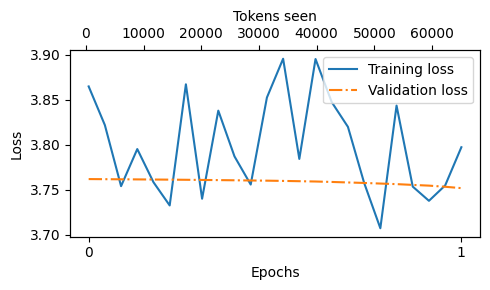

In [39]:
# Loss calculation and training utilities
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    # If model is GRITAdapter, use model.model for generation if hooks interfere
    # Or ensure GRITAdapter can be set to eval mode correctly for generation
    eval_model = model.model if isinstance(model, GRITAdapter) else model
    eval_model.eval()
    with torch.no_grad():
        token_ids = generate(
            model=eval_model, # Use eval_model
            idx=text_to_token_ids(start_context, tokenizer).to(device),
            max_new_tokens=35,
            context_size=BASE_CONFIG["context_length"],
            eos_id=50256,
        )
        generated_text = token_ids_to_text(token_ids, tokenizer)
        response_text = generated_text[len(start_context):]
        print(f"Generated response: {response_text.strip()}")
    # model.train() # GRITAdapter's mode or its underlying model's mode will be set in the loop
    if isinstance(model, GRITAdapter):
        model.model.train() # Set underlying model to train
        model.train() # Also set adapter to train if it has specific train mode behavior
    else:
        model.train()

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                      eval_freq, eval_iter, start_context, tokenizer, kfac_update_freq=100):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        if isinstance(model, GRITAdapter):
            model.model.train() # Set base model to train mode
            model.train()
        else:
            model.train()  # Set model to training mode for non-GRIT usage

        # Log rank changes at the beginning of each epoch for GRITAdapter
        if isinstance(model, GRITAdapter) and run:
            current_ranks = {}
            for name, l_module in model.model.named_modules():
                if isinstance(l_module, FlexLoRA):
                    current_ranks[f"rank/{name}"] = l_module.current_rank
            if current_ranks:
                # Corrected dictionary unpacking for logging
                log_payload = {"epoch": epoch, "global_step": global_step}
                log_payload.update(current_ranks)
                wandb.log(log_payload)
        
        for i, (input_batch, target_batch) in enumerate(train_loader):
            
            # User Suggestion Point 1: Forward pass through GRITAdapter.
            # The GRITAdapter.forward() method is called here, which in turn calls the base model.
            # If model is in training, GRITAdapter.forward() saves the output logits 
            # in model.current_model_logits_for_kfac.
            main_loss_logits = model(input_batch) 
            
            # User Suggestion Point 2 (Context): Compute the main cross-entropy loss.
            # This loss is used for empirical Fisher updates and potentially for main parameter updates.
            main_loss = torch.nn.functional.cross_entropy(main_loss_logits.flatten(0, 1), target_batch.flatten())

            if isinstance(model, GRITAdapter):
                # Check if it's time for a True Fisher update step
                if global_step > 0 and global_step % kfac_update_freq == 0 and model.current_model_logits_for_kfac is not None:
                    # User Suggestion Point 3: True Fisher step.
                    # LoRA gradients are zeroed before the KFAC-specific backward pass
                    # (aligning with User Suggestion Point 2's principle: "Before that, LoRA gradients are zeroed...").
                    for p in model.parameters(): # model.parameters() in GRITAdapter yields only trainable (LoRA) ones
                        if p.grad is not None:
                            p.grad.detach_() 
                            p.grad.zero_()   

                    # Detach the saved logits and sample new "labels" from the model's predictive distribution.
                    with torch.no_grad():
                        logits_for_sampling = model.current_model_logits_for_kfac.detach()
                        probs = torch.softmax(logits_for_sampling / 1.0, dim=-1) # Temperature = 1.0
                        sampled_labels = torch.multinomial(probs.view(-1, probs.shape[-1]), num_samples=1).view(logits_for_sampling.shape[:-1])
                        model.current_sampled_labels_for_kfac = sampled_labels
                    
                    # Compute the secondary cross-entropy (kfac_loss) using the original (graph-attached) logits
                    # and the newly sampled (detached) labels.
                    kfac_loss_logits = model.current_model_logits_for_kfac 
                    
                    kfac_loss = torch.nn.functional.cross_entropy(
                        kfac_loss_logits.flatten(0, 1), 
                        model.current_sampled_labels_for_kfac.flatten()
                    )
                    # The backward pass of kfac_loss populates KFAC gradient covariance (B_factor)
                    # using gradients from the model's own predictive distribution (True Fisher).
                    # It also populates .grad for LoRA parameters from this kfac_loss.
                    kfac_loss.backward() 

                    # User Suggestion Point 5 (invoked from True Fisher path): 
                    # GRITAdapter.step() applies KFAC updates, natural gradient (using kfac_loss grads),
                    # reprojection, rank adjustment, and momentum fusion, utilizing the True Fisher information.
                    model.step() 
                    
                    # Clear stored logits and labels after use.
                    model.current_sampled_labels_for_kfac = None 
                    model.current_model_logits_for_kfac = None 
                
                else: 
                    # User Suggestion Point 4: Empirical Fisher step.
                    # User Suggestion Point 2 (Backprop part): LoRA gradients are zeroed before the main loss backward pass
                    # to isolate empirical Fisher effects for KFAC and for the natural gradient step.
                    if hasattr(model, 'parameters'): 
                        for p in model.parameters(): # model.parameters() in GRITAdapter yields only trainable (LoRA) ones
                            if p.grad is not None:
                                p.grad.detach_() 
                                p.grad.zero_()   

                    # Backprop main loss: This populates KFAC B_factor with empirical Fisher gradients
                    # (from main_loss gradients) and populates .grad for LoRA parameters from main_loss.
                    main_loss.backward() 
                    
                    # User Suggestion Point 5 (invoked from Empirical Fisher path):
                    # GRITAdapter.step() applies KFAC updates (using empirical Fisher B_factor), 
                    # natural gradient (using main_loss grads), reprojection, rank adjustment, and momentum.
                    model.step() 
            
            elif optimizer: # Standard optimizer step for non-GRIT models or non-LoRA parameters
                # For non-GRIT models or if an optimizer manages non-LoRA params alongside GRIT
                optimizer.zero_grad()
                main_loss.backward() # Standard backward pass for the main loss
                optimizer.step()
            
            # For GRIT, optimizer.zero_grad() is implicitly handled for LoRA parameters by model.step()'s natural_gradient_step.

            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                # Log to WandB
                if run:
                    log_dict = {
                        "epoch": epoch + (i / len(train_loader)), # Log epoch as a float for intra-epoch steps
                        "train_loss": train_loss,
                        "val_loss": val_loss,
                        "tokens_seen": tokens_seen,
                        "global_step": global_step
                    }
                    # Log rank changes if GRITAdapter is used
                    if isinstance(model, GRITAdapter):
                        current_ranks_eval = {}
                        for name, l_module in model.model.named_modules():
                            if isinstance(l_module, FlexLoRA):
                                current_ranks_eval[f"rank/{name}"] = l_module.current_rank
                        if current_ranks_eval:
                            log_dict.update(current_ranks_eval) # Correctly update the dictionary
                    wandb.log(log_dict)

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

# Initial evaluation
# model.to(device) # GRITAdapter handles moving the model to device
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, grit_adapter, device, num_batches=5) # Use grit_adapter
    val_loss = calc_loss_loader(val_loader, grit_adapter, device, num_batches=5)   # Use grit_adapter

print("Initial training loss:", train_loss)
print("Initial validation loss:", val_loss)

# Train the model
start_time = time.time()
torch.manual_seed(123)

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
# The optimizer for GRIT will be handled by the natural_gradient_step within grit_adapter.step()
# If there were non-LoRA parameters to train with a standard optimizer, you would define it here for those.
# For pure LoRA fine-tuning with GRIT, an external optimizer for LoRA params is not used in the same way.

num_epochs = 1  # Increase this for better results

# Update WandB config with training parameters before starting training
if run: # Check if wandb.init was successful
    wandb.config.update({
        "num_epochs": num_epochs,
        "batch_size": batch_size, # batch_size is defined earlier
    })

train_losses, val_losses, tokens_seen = train_model_simple(
    grit_adapter, train_loader, val_loader, None, device, # Pass grit_adapter, optimizer is None
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer,
    kfac_update_freq=50 # Example: Update KFAC with True Fisher every 50 steps
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# Visualize training progress
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses, loss_plot_path):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(loss_plot_path)
    plt.show()

    # Log the plot to WandB
    if run: # Check if wandb run is active
        try:
            wandb.log({"training_loss_plot": wandb.Image(str(loss_plot_path))})
            logger.info(f"Loss plot {loss_plot_path} logged to WandB.")
        except Exception as e:
            logger.error(f"Failed to log loss plot to WandB: {e}")

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
# Ensure OUTPUT_DIR exists for saving the plot
loss_plot_file = OUTPUT_DIR / "loss-plot.pdf"
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses, loss_plot_file)

In [ ]:
# The number of parameters for a FlexLoRA layer is (in_features * rank) + (rank * out_features).
# For the 4 attention-related FlexLoRA layers (base Linear(1024, 1024)):
# lora_A: 1024 * 8 = 8192
# lora_B: 8 * 1024 = 8192
# Total per layer: 8192 + 8192 = 16384 parameters.
# Total for 4 attention layers: 4 * 16384 = 65536 parameters.
# For ff.layers.0 (base Linear(1024, 4096)):
# lora_A: 1024 * 8 = 8192
# lora_B: 8 * 4096 = 32768
# Total: 8192 + 32768 = 40960 parameters.
# For ff.layers.2 (base Linear(4096, 1024)):
# lora_A: 4096 * 8 = 32768
# lora_B: 8 * 1024 = 8192
# Total: 32768 + 8192 = 40960 parameters.
# Total parameters per TransformerBlock:
# 65536 (attention) + 40960 (ff.0) + 40960 (ff.2) = 147456 parameters.
# Total trainable parameters for 24 blocks:
# 147456 parameters/block * 24 blocks = 3,538,944 parameters.
# Percentage of trainable parameters:(gpt-2 medium 355M)
# (3,538,944 / 355,000,000) * 100 \approx 0.9969%
# The data is split into 85% for training (935 samples), 5% for validation (55 samples), and 10% for testing (110 samples). 
# Number of entries: 1100
# Training set length: 935
# Validation set length: 55
# Test set length: 110
# number of batches per epoch is 935 // 8 = 116

In [43]:
total_params_adapted_model = sum(p.numel() for p in grit_adapter.model.parameters())

grit_trainable_params = sum(p.numel() for p in grit_adapter.parameters())

if total_params_adapted_model > 0:
    percentage_updated_by_grit = (grit_trainable_params / total_params_adapted_model) * 100
    print(f"\\n--- GRIT Parameter Update Statistics ---")
    print(f"Total parameters in the adapted model (base + LoRA): {total_params_adapted_model:,}")
    print(f"Trainable parameters (LoRA, updated by GRIT): {grit_trainable_params:,}")
    print(f"Percentage of parameters updated by GRIT: {percentage_updated_by_grit:.4f}%")
    print(f"----------------------------------------\\n")
else:
    print("Model has no parameters, cannot calculate GRIT update statistics.")

\n--- GRIT Parameter Update Statistics ---
Total parameters in the adapted model (base + LoRA): 409,825,280
Trainable parameters (LoRA, updated by GRIT): 107,614,208
Percentage of parameters updated by GRIT: 26.2586%
----------------------------------------\n


# STEP 6: EXTRACTING AND SAVING RESPONSES


In [46]:
torch.manual_seed(123)
grit_adapter.eval() # Ensure the GRIT-adapted model is in evaluation mode

# Generate responses for test examples
for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=grit_adapter, # Use the fine-tuned grit_adapter
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print("\nInput:", input_text)
    print(f"\nCorrect response: {entry['output']}")
    print(f"\nModel response: {response_text.strip()}")
    print("-------------------------------------")

# Process all test examples and save results
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=grit_adapter, # Use the fine-tuned grit_adapter
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()
    test_data[i]["model_response"] = response_text

# Save results to file
with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

# Save the fine-tuned model
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-grit-sft.pth"
# torch.save(model.state_dict(), file_name) # Save original model state
torch.save(grit_adapter.state_dict(), file_name) # Save only LoRA params via GRITAdapter
print(f"GRIT Adapter LoRA parameters saved as {file_name}")

# Finish WandB run at the very end of the script
if run: # Check if wandb run is active
    run.finish()
    logger.info("WandB run finished.")

# To load the model with GRIT LoRA weights:
# 1. Load the base GPTModel: model = GPTModel(BASE_CONFIG); load_weights_into_gpt(model, params);
# 2. Instantiate GRITAdapter: grit_adapter = GRITAdapter(model, layers_to_adapt_substrings=layers_to_adapt, ...)
# 3. Load the LoRA weights: grit_adapter.load_state_dict(torch.load(file_name))
# 4. grit_adapter.to(device)
# 5. model.eval() (or grit_adapter.model.eval() / grit_adapter.eval()) 


Input: Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response: The car is as fast as lightning.

Model response: ### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The ca

100%|██████████| 110/110 [1:19:34<00:00, 43.40s/it]

GRIT Adapter LoRA parameters saved as gpt2-medium355M-grit-sft.pth


epoch,▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
global_step,▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
rank/trf_blocks.0.att.W_key,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rank/trf_blocks.0.att.W_query,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rank/trf_blocks.0.att.W_value,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rank/trf_blocks.0.att.out_proj,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rank/trf_blocks.0.ff.layers.0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rank/trf_blocks.0.ff.layers.2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rank/trf_blocks.1.att.W_key,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rank/trf_blocks.1.att.W_query,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rank/trf_blocks.1.att.W_value,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


# STEP 7: EVALUATE THE FINE-TUNED LLM WITH GROQ


In [54]:
!pip install groq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.2 MB/s eta 0:00:00


In [55]:
from groq import Groq

In [56]:
# Setup Groq Authentication
def setup_groq_auth():
    """Set up Groq authentication using Kaggle secrets."""
    if UserSecretsClient:
        try:
            user_secrets = UserSecretsClient()
            groq_api_key = user_secrets.get_secret("GROQ_API_KEY")
            if groq_api_key:
                os.environ["GROQ_API_KEY"] = groq_api_key
                logger.info("Successfully set GROQ_API_KEY environment variable from Kaggle secrets.")
            else:
                logger.warning("GROQ_API_KEY not found in Kaggle secrets. Groq API calls may fail.")
        except Exception as e:
            logger.error(f"Failed to set Groq API key using Kaggle secrets: {e}. "
                         f"Ensure GROQ_API_KEY secret is set in Kaggle or GROQ_API_KEY env var is set.")
    elif os.environ.get("GROQ_API_KEY"):
        logger.info("GROQ_API_KEY environment variable already set.")
    else:
        logger.warning("Groq API key not found in Kaggle secrets or environment variables. Groq API calls may fail.")

setup_groq_auth() # Call Groq authentication function

In [58]:
# Initialize Groq client (it will use the GROQ_API_KEY from env)
try:
    groq_client = Groq()
    logger.info("Groq client initialized successfully.")
except Exception as e:
    groq_client = None
    logger.error(f"Failed to initialize Groq client: {e}. Evaluation will be skipped.")

def query_model_groq(
    prompt: str,
    client: Groq,
    model_name: str = "llama3-8b-8192", # Default to a common Groq model, user can change
    max_tokens: int = 100, # Reduced max_tokens for scoring
    temperature: float = 0.0, # For deterministic output
    top_p: float = 1.0
):
    """
    Queries a model using the Groq API.
    """
    if not client:
        logger.error("Groq client not available. Cannot query model.")
        return "Error: Groq client not available."
    try:
        completion = client.chat.completions.create(
            model=model_name,
            messages=[
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            temperature=temperature,
            max_tokens=max_tokens,
            top_p=top_p,
            stream=False, # We want the full response for scoring
            # stop=None, # Not typically needed for scoring
        )
        response_content = completion.choices[0].message.content
        return response_content
    except Exception as e:
        logger.error(f"Error querying Groq model {model_name}: {e}")
        return f"Error during Groq API call: {e}"


if groq_client: # Proceed with evaluation only if Groq client is available
    logger.info("Starting evaluation with Groq...")
    # Example evaluation using Groq
    groq_eval_model_name = "llama3-8b-8192" # Or "mixtral-8x7b-32768", "gemma-7b-it" etc.
                                         # User should choose a model available on Groq

    for entry in test_data[:3]:
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry['model_response']}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        print("\\nDataset response:")
        print(">>", entry['output'])
        print("\\nModel response:")
        print(">>", entry["model_response"])
        print("\\nScore:")
        score = query_model_groq(prompt, groq_client, model_name=groq_eval_model_name)
        print(">>", score)
        print("\\n-------------------------")

    def generate_model_scores_groq(json_data, json_key, client: Groq, model_name: str ="llama3-8b-8192"):
        scores = []
        if not client:
            logger.error("Groq client not available for generating scores.")
            return scores # Return empty list if client is not available

        for entry in tqdm(json_data, desc="Scoring entries with Groq"):
            prompt = (
                f"Given the input `{format_input(entry)}` "
                f"and correct output `{entry['output']}`, "
                f"score the model response `{entry[json_key]}`"
                f" on a scale from 0 to 100, where 100 is the best score. "
                f"Respond with the integer number only."
            )
            score_text = query_model_groq(prompt, client, model_name=model_name)
            try:
                # Attempt to clean up the score if it includes non-numeric characters
                cleaned_score = "".join(filter(str.isdigit, score_text.split(":")[-1].strip()))
                if cleaned_score:
                    scores.append(int(cleaned_score))
                else: # Handle case where no digits are found after cleaning
                    logger.warning(f"Could not parse score (no digits found after cleaning): '{score_text}' for input: {format_input(entry)[:50]}...")
            except ValueError:
                logger.warning(f"Could not convert score to int: '{score_text}' for input: {format_input(entry)[:50]}...")
                continue
            except Exception as e: # Catch any other unexpected errors during parsing
                logger.error(f"Unexpected error parsing score '{score_text}': {e} for input: {format_input(entry)[:50]}...")
                continue


        return scores

    # Generate scores for the model responses
    # Make sure 'instruction-data-with-response.json' exists from STEP 6
    # Or, if test_data is already populated with 'model_response', use that directly.
    # Assuming test_data (from STEP 6) has 'model_response' populated.
    if any('model_response' in entry for entry in test_data):
        model_scores_groq = generate_model_scores_groq(test_data, "model_response", groq_client, model_name=groq_eval_model_name)
        if model_scores_groq:
            average_score_groq = sum(model_scores_groq) / len(model_scores_groq)
            print(f"\nAverage score from Groq evaluation: {average_score_groq:.2f}")
            if wandb.run: # Changed from 'if run:'
                wandb.log({"average_groq_score": average_score_groq, "groq_eval_model": groq_eval_model_name})
        else:
            print("\nNo scores generated from Groq evaluation.")
    else:
        print("\n'model_response' key not found in test_data. Skipping Groq score generation.")

else:
    logger.warning("Groq client failed to initialize. Evaluation with Groq will be skipped.")


# Finish WandB run if it was initialized
if run:
    run.finish()
    logger.info("WandB run finished.")

\nDataset response:
>> The car is as fast as lightning.
\nModel response:
>> ### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output
\nScore:
>> 0
\n--

Scoring entries with Groq: 100%|██████████| 110/110 [04:36<00:00,  2.51s/it]


Average score from Groq evaluation: 46.49
